In [3]:
%cd ~/ocr-debug-jupyter-app/app
%ls
import logging
import matplotlib.pyplot as plt
import cv2
import numpy as np
import re
# from docker_manager import DockerManager
# from scanner import ScannerClient
from model_serving.client import ModelServerClient
from ocr2 import InsuranceReader
from ocr2.info_extractor import MainAnalyzer
class FakeDockerManger:
    def run_if_not_yet(*args, **kwargs):
        pass
    def stop(*args, **kwargs):
        pass
logger=logging.getLogger()
docker_manager = FakeDockerManger()
analyzers = {"主保険": MainAnalyzer()}
model_server = ModelServerClient(docker_manager=docker_manager, logger=logger)
reader = InsuranceReader(model_server=model_server, analyzers=analyzers, logger=logger)

/home/user/ocr-debug-jupyter-app/app
config/            img/                ocr2/         utils.py
debug/             img-err/            __pycache__/  ws_server_rpc.py
docker_manager.py  libempia_xuctrl.so  scanner/
entrypoint.py      model_serving/      test/


{'lines': array([[ 772.35187  ,  812.17847  , 1167.7732   ,  812.17847  ,
         1167.7732   ,  864.8065   ,  772.35187  ,  864.8065   ],
        [ 406.8004   ,  807.9113   ,  741.0595   ,  807.9113   ,
          741.0595   ,  860.53937  ,  406.8004   ,  860.53937  ],
        [ 278.78632  ,  803.64417  ,  371.24094  ,  803.64417  ,
          371.24094  ,  861.96173  ,  278.78632  ,  861.96173  ],
        [ 237.53731  ,  803.64417  ,  308.65625  ,  803.64417  ,
          308.65625  ,  860.53937  ,  237.53731  ,  860.53937  ],
        [  31.29234  ,  797.95465  ,  267.40726  ,  797.95465  ,
          267.40726  ,  864.8065   ,   31.29234  ,  864.8065   ],
        [ 908.90027  ,  742.4819   , 1281.5636   ,  742.4819   ,
         1281.5636   ,  799.3771   ,  908.90027  ,  799.3771   ],
        [ 405.37805  ,  742.4819   ,  943.03735  ,  742.4819   ,
          943.03735  ,  797.95465  ,  405.37805  ,  797.95465  ],
        [ 304.38913  ,  742.4819   ,  372.66333  ,  742.4819   ,
         

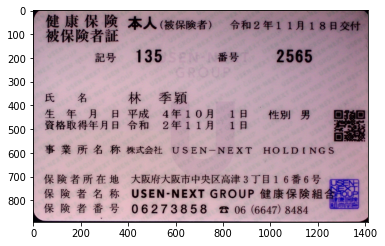

In [4]:
img = cv2.imread('/ori_img/2021_04_20_13_50_43.jpg')
plt.imshow(img)
if img.shape[0] > img.shape[1]:
    layout = 'portrait'
else:
    layout = 'landscape'
det_res = model_server.infer_sync(
    sess_id='123', network='Det',
    img=img,
    layout=layout,
    suppress_lines=False,
    check_local=False
)
det_res

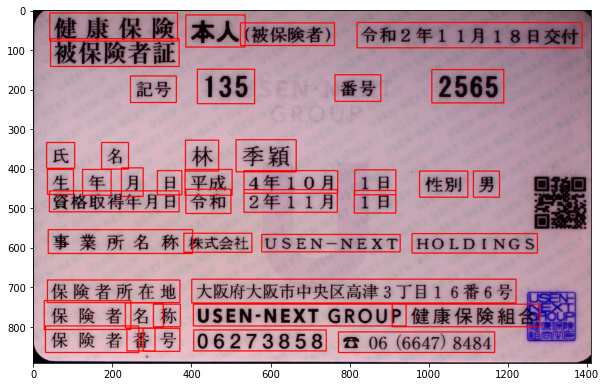

In [23]:
def draw_boxes(img, texts):
    img_draw = img.copy()
    for b in texts:
        b = b.astype(int)
        img_draw = cv2.rectangle(img_draw, (b[0], b[1]), (b[4], b[5]), (255, 0, 0), 2)
    return img_draw
plt.figure(figsize=(10, 10))
plt.imshow(draw_boxes(img, det_res['lines']))
# plt.imshow(draw_boxes(img, text_boxes))


In [15]:
from typing import List,Any

def get_chips(img: np.ndarray, boxes: np.ndarray) -> List[np.ndarray]:
    """Gets images chips from an image based on given bounding boxes.

    Args:
    img: Image to extract chips from
    boxes: Bounding boxes

    Returns:
    A list of image chips, each of which is a numpy array.
    """
    assert len(boxes.shape) == 2 and boxes.shape[1] == 4
    assert (boxes >= 0).all(), 'expect all coords to be non-negative'
    chips = []
    for b in boxes.astype(int):
        x1 = min(max(b[0], 0), img.shape[1] - 2)
        x2 = max(b[2], x1 + 1)
        y1 = min(max(b[1], 0), img.shape[0] - 2)
        y2 = max(b[3], y1 + 1)
        chips.append(img[y1:y2, x1:x2])
    return chips
def get_rect(polygons: np.ndarray, min_wh_ratio: float = 0) -> np.ndarray:
    """Gets rectangles from polygons.

    Args:
    polygons: 2d numpy array with a shape of (n, 8), where n is number of
      polygons. If the 2nd dimension is larger than 8, only the first 8
      numbers will be used.
    min_wh_ratio: Minimum width-height ratio for a valid rectangle

    Returns:
    A 2d numpy array with a shape of (n, 4), where n is number of rectangles.
    """
    polygons = polygons[:, :8]
    rects = []
    for polygon in polygons:
        pts = polygon.reshape(4, 2)
        x0, x1 = pts[:, 0].min(), pts[:, 0].max()
        #y0, y1 = pts[:, 1].min(), pts[:, 1].max()
        y0, y1 = pts[:2, 1].mean(), pts[2:, 1].mean()
        if y1 - y0 < 8 or x1 - x0 < 8: continue
        if (x1 - x0) / (y1 - y0) > min_wh_ratio:
            rects.append([x0, y0, x1, y1])
    rects = np.array(rects)
    return rects
def group_lines(
    texts: List[List[Any]],
    iou_threshold: float = 0.4
) -> List[List[Any]]:
    """Groups texts with bounding boxes in lines.

    Args:
    texts: A list of OCR result, each element of which is also a list of
      [text, probability, position, bouding_box]
    iou_threshold: Threshold for IOU in vertical direction to determine if
      two bounding boxes belong to the same line.

    Returns:
    A list of lists of bouding boxes belonging to the same line.
    """
    grouped = []
    texts = sorted(texts, key=lambda x: (x[-1][1] + x[-1][3]) / 2)
    current_line = []
    for text in texts:
        if not current_line:
            current_line.append(text)
            continue
        y0s = [t[-1][1] for t in current_line]
        y1s = [t[-1][3] for t in current_line]
        inter = np.minimum(y1s, text[-1][3]) - np.maximum(y0s, text[-1][1])
        inter = np.maximum(inter, 0)
        union = np.maximum(y1s, text[-1][3]) - np.minimum(y0s, text[-1][1])
        iou = inter / union
        if iou.mean() > iou_threshold:
            current_line.append(text)
        else:
            current_line = sorted(current_line, key=lambda x: (x[-1][0] + x[-1][2]) / 2)
            current_line.append(''.join([w[0] for w in current_line]))
            grouped.append(current_line)
            current_line = [text]
    current_line = sorted(current_line, key=lambda x: (x[-1][0] + x[-1][2]) / 2)
    current_line.append(''.join([w[0] for w in current_line]))
    grouped.append(current_line)
    return grouped


In [36]:
lines=det_res['lines']
print(len(lines))
text_boxes = get_rect(lines, min_wh_ratio=0.5)
print(len(text_boxes))
chips = get_chips(img,text_boxes)

recog_res_dict = model_server.infer_batch_sync(
        sess_id='123',
        network='Dense',
        imgs=chips,
        num_onlys=[False]*len(text_boxes),
        check_local=False
    )



42
42


In [25]:
import pickle

id2_path='/home/user/ocr-debug-jupyter-app/app/ocr2/id2char_std.pkl'
with open(id2_path, 'rb') as f:
    id2char = pickle.load(f)
len(id2char)
for code in recog_res_dict['codes']:
#     print(code)
    temp =[]
    for i in code:
        temp.append(id2char[i])
    print(temp)

['☎', '０', '６', '（', '６', '６', '４', '７', '）', '８', '４', '８', '４']
['０', '６', '２', '７', '３', '８', '５', '８']
['号']
['番']
['保', '険', '者', '１']
['ｐ', '健', '康', '保', '険', '組', '合']
['ｕ', 'ｓ', 'ｅ', 'ｎ', '・', 'ｎ', 'ｅ', 'ｘ', 'ｔ', 'ｇ', 'ｒ', 'ｏ', 'ｕ', 'ｐ']
['称']
['名', 'ｊ']
['保', '険', '者']
['大', '阪', '府', '大', '阪', '市', '中', '央', '区', '高', '津', '３', '丁', '目', '１', '６', '番', '６', '号']
['保', '険', '者', '所', '在', '地']
['ｈ', 'ｏ', 'ｌ', 'ｄ', 'ｉ', 'ｎ', 'ｇ', 'ｓ']
['ｕ', 'ｓ', 'ｅ', 'ｎ', 'ー', 'ｎ', 'ｅ', 'ｘ', 'ｔ']
['株', '式', '会', '社']
['事', '業', '所', '名', '称', 'オ']
['資', '格', '取', '得', '年', '月', '日']
['２', '年', '１', '１', '月']
['１', '日']
['令', '和']
['性', '別']
['４', '年', '１', '０', '月']
['男']
['１', '日']
['平', '成']
['日']
['年']
['月']
['生']
['季', '穎']
['名']
['氏']
['林']
['記', '号']
['番', '号']
['２', '５', '６', '５']
['１', '３', '５']
['被', '保', '険', '者', '証']
['令', '和', '２', '年', '１', '１', '月', '１', '８', '日', '交', '付']
['（', '被', '保', '険', '者', '）']
['本', '人']
['健', '康', '保', '険']


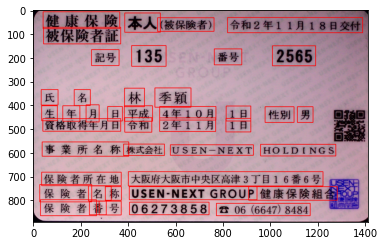

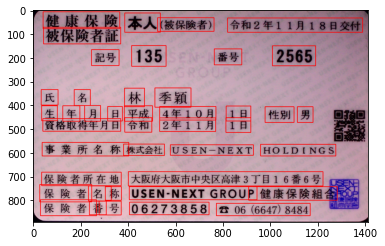

In [24]:
def draw_text_boxes(img, texts):
    img_draw = img.copy()
    for b in texts:
        b = b.astype(int)
        img_draw = cv2.rectangle(img_draw, (b[0], b[1]), (b[2], b[3]), (255, 0, 0), 2)
    return img_draw
plt.imshow(draw_boxes(img, det_res['lines']))
plt.show()
plt.imshow(draw_text_boxes(img, text_boxes))
plt.show()

In [27]:
text_boxes.shape
det_res['lines'].shape

(42, 8)

In [26]:
pth=0.5
recog_results = []
for idx, (box, codes) in enumerate(zip(
        text_boxes,
        recog_res_dict["codes"]
    )):
    probs, positions = (
      recog_res_dict["probs"][idx],
      recog_res_dict["positions"][idx],
    )
    if codes.size == 0:
        continue
    indices = probs > pth
    probs = probs[indices]
    positions = positions[indices]
    codes = codes[indices]
    text = "".join([id2char[c] for c in codes])
    if text:
        recog_results.append([text, probs, positions, box])

    # group text areas in lines
    texts = group_lines(recog_results)

In [28]:
for i in texts:
    print(i[-1])

健康保険本人（被保険者）令和２年１１月１８日交付
被保険者証
記号１３５番号２５６５
氏名林季穎
生年月日平成４年１０月１日性別男
資格取得年月日令和２年１１月１日
事業所名称株式会社ｕｓｅｎーｎｅｘｔｈｏｌｄｉｎｇｓ
保険者所在地大阪府大阪市中央区高津３丁目１６番６号
保険者名称ｕｓｅｎ・ｎｅｘｔｇｒｏｕｐｐ健康保険組合
保険者１番号０６２７３８５８☎０６（６６４７）８４８４
